In [15]:
from PIL import Image, ImageOps
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier

In [3]:
def aanmakenDf (groep, label):
#Drie lege lijsten worden aangemaakt die dan uiteindelijk samen dataframe zullen vormen 
    Pixels= []
    Label =[]
    Naam=[]
  
#fotos inlezen en omzetten per groep. 
    for foto in os.listdir(groep):
        beeld = Image.open(groep+foto)
#fotos omzetten in grijswaarde of 2 dimensionele array ipv 3x2
        beeld_grijs = ImageOps.grayscale(beeld)

#fotos resizen voor leesbaarheid tijdens testen, en eventueel voor latere experimenten
        beeld_formaat = beeld_grijs.resize((beeld_grijs.width // 4, beeld_grijs.height //4 ))       
        
#fotos omzetten naar numpy array
        data_2dim = np.asarray(beeld_formaat, dtype=np.uint8)
        data = data_2dim.flatten()

#3 lijsten opvullen, eerste met data van foto, tweede met label en derde met naam van foto. 
#De lengte van elke lijst = aantal fotos in bijhorende map
        Pixels.append(data)
        Label.append(label)
        Naam.append(foto)

#Per groep worden de drie aangemaakte lijsten omgezet naar panda df
    dict = {'data': Pixels, 'label': Label, 'naam': Naam}
    df = pd.DataFrame(dict)
    return df

In [4]:
aanwezig = r"classificatie/aanwezig/"  #852 foto's 
buiten = r"classificatie/buiten/"       #389 foto's
niets = r"classificatie/niets/"         #1399 foto's
#Eerst wordt per map een panda dataframe aangemaakt
nietsDf = aanmakenDf(niets, 0)
aanwezigDf = aanmakenDf(aanwezig, 1)
buitenDf = aanmakenDf(buiten, 2)
#vervolgens worden ze alle drie samengevoegd tot 1 groot dataframe
volledigDataframe = pd.concat([nietsDf, aanwezigDf, buitenDf], ignore_index=True)

In [5]:
#Opsplitsen in gestratificieerde testset en trainingsset
np.random.seed(42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(volledigDataframe, volledigDataframe['label']):
    strat_train_set = volledigDataframe.loc[train_index]
    strat_test_set = volledigDataframe.loc[test_index] 
#X = data, y = label. Dit voor trainingsset en testset  
X_train, X_test, y_train, y_test = strat_train_set['data'], strat_test_set['data'], strat_train_set['label'], strat_test_set['label']

In [6]:
#Omzetten naar np.array
X_train_array = np.array(X_train.tolist())
X_test_array = np.array(X_test.tolist())
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

X_train_array.shape

(2112, 14080)

In [7]:
#Binaire classificatie
y_train_niets = (y_train_array == 0)
y_test_niets = (y_test_array == 0)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_array, y_train_niets)

(sgd_clf.predict([X_test_array[0]]))  
(sgd_clf.predict([X_test_array[2]]))  

array([False])

In [8]:
y_test_array[2]

2

In [9]:
#Cross Validatie: trainingsset opdelen in 3 delen
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_array, y_train_niets, cv=3, scoring="accuracy")

array([0.91051136, 0.84517045, 0.83664773])

Cross validatie verwacht op basis van gokken is ongeveer 50´%

Bij aantal pixels gedeeld door 32, tussen 70 en 75% van gevallen correct

Bij aantal pixels gedeeld door 4, tussen 83 en 91% correct

Bij totale aantal pixels: tussen 83 en 92% correct (leertijd 35 sec, crossvalidatie tijd 92 sec)

In [10]:
#Cross validatie adhv confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_array, y_train_niets, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_niets, y_train_pred)

array([[ 758,  235],
       [  52, 1067]], dtype=int64)

Confusion matrix bij totaal aantal pixels:

[[854, 139],

 [150, 969]]

Confusion matrix bij aantal pixels/4:

[[ 758,  235],

[  52, 1067]]

Hier: (zou eigenlijk beter omgekeerd...)

positief als er geen kat wordt herkend en er ook effectief geen is (true)

negatief als er wel een kat wordt herkend en er ook effectief een is (false)

vals negatief: kat is er niet, maar algoritme zegt van wel

vals positief: kat is er wel, maar algoritme denkt van niet

Hier dus vooral te vermijden: vals positief!!! Precision wordt verhoogd door de vals positieve te verlagen


In [11]:
#Precision en Recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_niets, y_train_pred) 

0.8195084485407066

In [12]:
recall_score(y_train_niets, y_train_pred)

0.9535299374441466

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_niets, y_train_pred)

0.8814539446509707

Treshold kan worden opgeschoven naar meer precision:  Precision Recall curve

In [13]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train_array, y_train_niets, cv=3,
method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_niets, y_scores)

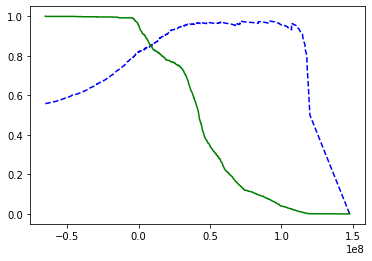

In [16]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
#Kiezen van mate van precisie. Hier kan mee worden gespeeld.
#Op basis hiervan bepalen hoeveel foto's uit analyse worden verwijderd...???
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

17510254.30472343

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_niets, y_train_pred_90)

0.9006085192697769

In [33]:
recall_score(y_train_niets, y_train_pred_90)

0.7935656836461126

In [34]:
f1_score(y_train_niets, y_train_pred_90)

0.8437054631828979

In [ ]:
#Multiclass classificatie
